In [26]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sklearn as sk
import os
from IPython.display import clear_output, display
try:
    from treeinterpreter import treeinterpreter as ti
except:
    !pip install treeinterpreter
    from treeinterpreter import treeinterpreter as ti

In [6]:
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/heart-disease-uci.zip',compression='zip')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


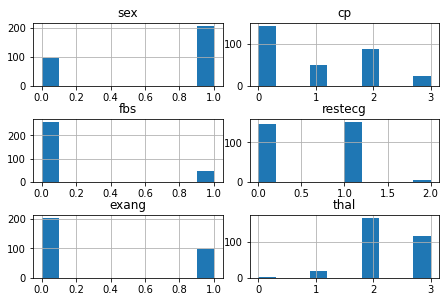

In [8]:
df[['sex','cp','fbs','restecg','exang','thal']].hist();
plt.tight_layout(False)

In [9]:
from sklearn.model_selection import train_test_split
train, test  = train_test_split(df,test_size=0.2)
train, valid = train_test_split(train,test_size=0.1)

train_x = train.copy()
train_y = train_x.pop('target')
valid_x = valid.copy()
valid_y = valid_x.pop('target')
test_x  = test.copy()
test_y  = test_x.pop('target')

pd.concat([train_x,train_y],axis=1).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
62,52,1,3,118,186,0,0,190,0,0.0,1,0,1,1
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
21,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2,1


In [10]:
df.iloc[[80,59,186],:].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1
59,57,0,0,128,303,0,0,159,0,0.0,2,1,2,1
186,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0


In [12]:
from tensorflow import feature_column 
from tensorflow.keras import layers
fc = tf.feature_column
NUMERIC_COLUMNS     = ['age','trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']
BUCKETIZED_COLUMNS  = [(feature_column.numeric_column('age',dtype=tf.float32),list(np.linspace(15,65,11)))]
CATEGORICAL_COLUMNS = ['sex','cp','fbs','restecg','exang']
#embedding_column在BoostedTreesClassifier怪怪的
EMBEDDING_COLUMNS   = []#[(feature_column.categorical_column_with_identity('thal',100000),8)]
HASHED_COLUMNS      = [('thal',100)]
CROSSED_COLUMNS     = [(feature_column.bucketized_column(feature_column.numeric_column('age',dtype=tf.float32),list(np.linspace(15,65,11))),
                        feature_column.categorical_column_with_vocabulary_list('thal',train_x['thal'].unique(),dtype=tf.int32),100)]
feature_columns = []
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(feature_column.numeric_column(feature_name,dtype=tf.float32))
for (nc,boundaries) in BUCKETIZED_COLUMNS:
    feature_columns.append(feature_column.bucketized_column(nc,boundaries=boundaries))
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_x[feature_name].unique()
    one_hot    = feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary)
    feature_columns.append(feature_column.indicator_column(one_hot))
for (c_fc,dim) in EMBEDDING_COLUMNS:
    ec = feature_column.embedding_column(c_fc,dimension=dim)
    feature_columns.append(ec)
for (feature_name,hash_bucket_size) in HASHED_COLUMNS:
    hashed_bucket = feature_column.categorical_column_with_hash_bucket(feature_name,hash_bucket_size=hash_bucket_size,dtype=tf.int32)
    feature_columns.append(feature_column.indicator_column(hashed_bucket))
for (f1,f2,hash_bucket_size) in CROSSED_COLUMNS:
    crossed_feature = feature_column.crossed_column([f1,f2],hash_bucket_size=hash_bucket_size)
    feature_columns.append(feature_column.indicator_column(crossed_feature))

In [13]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(len(y))
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(len(y))
        return dataset
    return input_fn
# Training and evaluation input functions.
train_input_fn = make_input_fn(train_x, train_y)
valid_input_fn = make_input_fn(valid_x, valid_y)
test_input_fn  = make_input_fn(test_x, test_y,1)    

In [14]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_input_fn(),epochs=30,validation_data=valid_input_fn(),steps_per_epoch=10,validation_steps=10,verbose=0)
results = model.evaluate(test_input_fn(),verbose=0)
pd.Series({'loss':results[0],'acc':results[1]}).to_frame()

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


,0
loss,0.309227
acc,0.852459


In [15]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns,**params)

est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps0ztvysh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Plea

In [18]:
results = est.evaluate(test_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.852459
accuracy_baseline,0.557377
auc,0.934096
auc_precision_recall,0.937428
average_loss,0.323819
label/mean,0.557377
loss,0.323819
precision,0.857143
prediction/mean,0.525674
recall,0.882353


In [19]:
pd.DataFrame({name:[v] for name,v in est.experimental_feature_importances().items()}).T

,0
cp,0.676569
ca,0.595667
thal,0.363549
thalach,0.316758
oldpeak,0.210175
age_bucketized_X_thal,0.195132
chol,0.193061
age,0.190799
slope,0.175693
trestbps,0.126885


In [20]:
pred_dicts = list(est.experimental_predict_with_explanations(make_input_fn(train_x, train_y,1)))
# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps0ztvysh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tens

,count,mean,std,min,25%,50%,75%,max
ca,217.0,0.108823,0.042328,0.000772,0.089569,0.115739,0.130014,0.241891
cp,217.0,0.077085,0.037377,0.000905,0.048393,0.066026,0.108948,0.167359
oldpeak,217.0,0.054395,0.030514,0.001180,0.030228,0.057313,0.076383,0.245168
thal,217.0,0.046925,0.015123,0.031493,0.036532,0.040051,0.049452,0.101694
thalach,217.0,0.039405,0.037292,0.000309,0.009375,0.024904,0.069571,0.169079
age_bucketized_X_thal,217.0,0.038888,0.034605,0.001577,0.009594,0.023619,0.067683,0.169596
slope,217.0,0.032016,0.019528,0.006226,0.020073,0.026186,0.039501,0.101671
exang,217.0,0.027676,0.026771,0.004310,0.011120,0.017667,0.032983,0.131442
trestbps,217.0,0.027206,0.029988,0.000021,0.005051,0.015656,0.040542,0.151009
age,217.0,0.024575,0.027521,0.000078,0.007569,0.018388,0.032699,0.229203


In [21]:
pred_dicts = list(est.experimental_predict_with_explanations(test_input_fn))
# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmps0ztvysh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tens

,count,mean,std,min,25%,50%,75%,max
ca,61.0,0.106936,0.040924,0.008730,0.094673,0.114513,0.134076,0.185543
cp,61.0,0.072593,0.040399,0.013544,0.045635,0.061887,0.109011,0.174490
oldpeak,61.0,0.053824,0.026579,0.003027,0.030779,0.055753,0.073954,0.113389
thal,61.0,0.046860,0.014477,0.032138,0.036701,0.040200,0.048866,0.078948
age_bucketized_X_thal,61.0,0.041153,0.032325,0.003193,0.014319,0.030004,0.068141,0.153666
thalach,61.0,0.034859,0.035305,0.001086,0.007566,0.023321,0.045916,0.145651
slope,61.0,0.033656,0.020066,0.006702,0.021685,0.026024,0.040874,0.090767
trestbps,61.0,0.030001,0.028463,0.000389,0.009103,0.024349,0.036869,0.116597
exang,61.0,0.028520,0.028070,0.005274,0.010398,0.020313,0.032983,0.136479
sex,61.0,0.024035,0.031971,0.000113,0.003292,0.006790,0.036168,0.138400


In [22]:
pd.DataFrame([pred_dicts[2]['dfc']]).abs().head(1).T

,0
ca,0.135473
sex,0.077962
thal,0.068440
cp,0.042138
oldpeak,0.028372
exang,0.023424
slope,0.019100
age,0.017096
chol,0.016914
age_bucketized_X_thal,0.016393


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=96)
rf_clf.fit(train_x, train_y)
rf_acc = rf_clf.score(test_x,test_y)
print('random forest accuracy: {:.3f}'.format(rf_acc))

random forest accuracy: 0.902


In [24]:
pd.DataFrame({name:[cr] for cr,name  in zip(rf_clf.feature_importances_,train_x.columns)}).head().T.sort_values([0],ascending=False)   

,0
cp,0.149981
ca,0.139431
thalach,0.117856
oldpeak,0.094057
age,0.083862
trestbps,0.081814
chol,0.079633
thal,0.077344
slope,0.057796
exang,0.056947


In [27]:
prediction, bias, contributions = ti.predict(rf_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.127980
ca,0.122285
thal,0.070018
thalach,0.060429
oldpeak,0.057279
slope,0.055284
exang,0.052596
age,0.036214
chol,0.033868
sex,0.030481


In [28]:
prediction, bias, contributions = ti.predict(rf_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.126047
ca,0.117291
thal,0.071914
slope,0.055565
exang,0.052165
oldpeak,0.051933
thalach,0.048422
sex,0.034432
age,0.031104
chol,0.021563


In [29]:
instance_id = 10
prediction, bias, contributions = ti.predict(rf_clf, test_x[instance_id:instance_id+1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:,class_id])).ravel())}).head().T.sort_values([0],ascending=False)

,0
ca,0.155024
cp,0.109774
oldpeak,0.094475
thal,0.082145
slope,0.054850
chol,0.051159
sex,0.043743
exang,0.034546
trestbps,0.017349
age,0.014608


In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt_clf = DecisionTreeClassifier(random_state=96)
dt_clf.fit(train_x,train_y)
dt_acc = dt_clf.score(test_x,test_y)
print('decision tree accuracy: {:.3f}'.format(dt_acc))

decision tree accuracy: 0.803


In [31]:
pd.DataFrame({name:[cr] for cr,name  in zip(dt_clf.feature_importances_,train_x.columns)}).head().T.sort_values([0],ascending=False)   

,0
cp,0.269373
ca,0.162708
slope,0.105405
thalach,0.082006
chol,0.072124
sex,0.057084
thal,0.054122
trestbps,0.052619
age,0.051442
oldpeak,0.042681


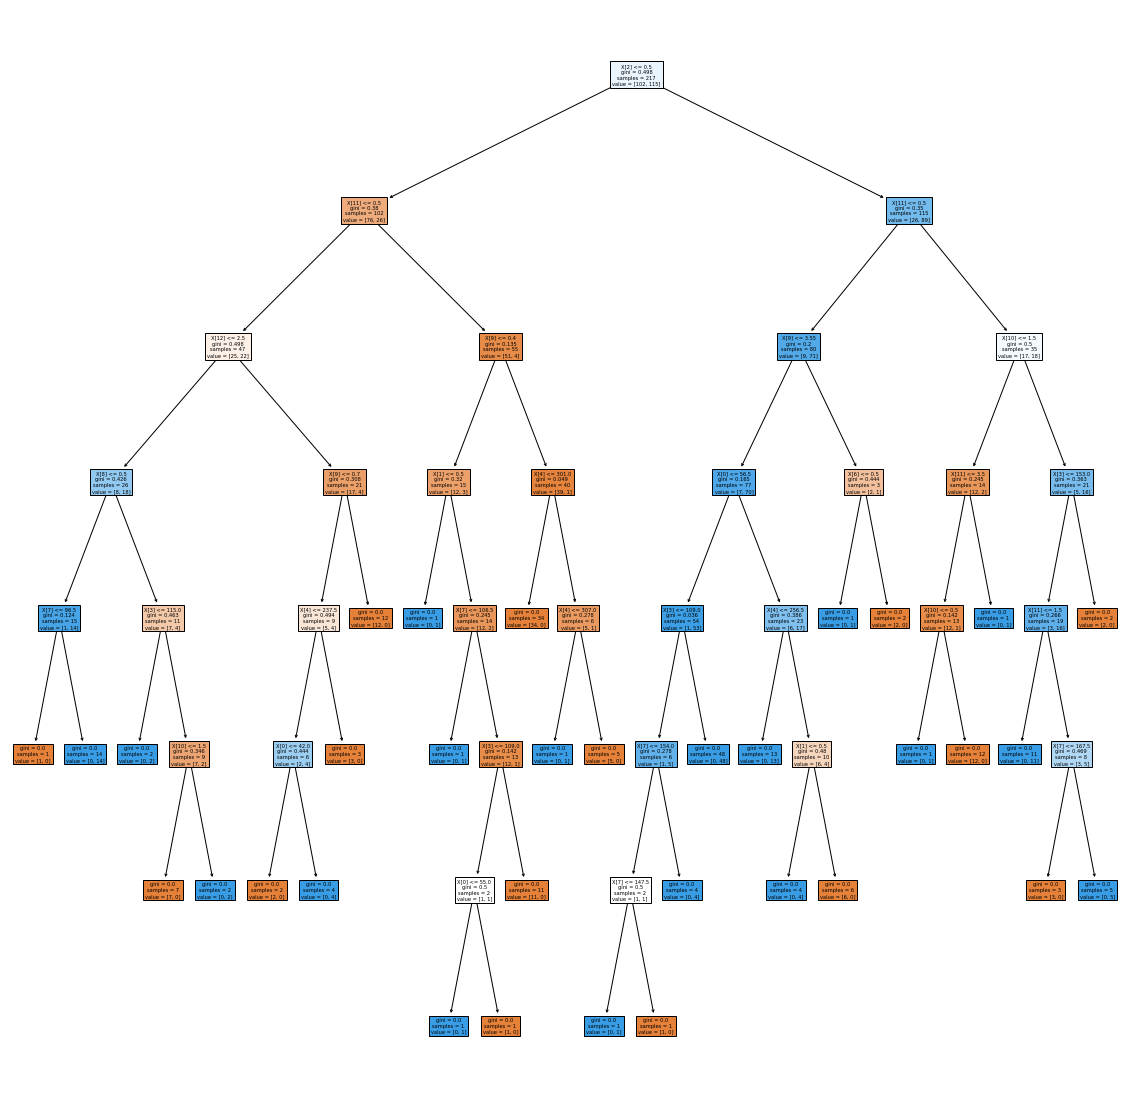

In [32]:
plt.figure(figsize=(20,20))
a=plot_tree(dt_clf, filled=True) 
plt.savefig('decision_tree.pdf')

In [33]:
prediction, bias, contributions = ti.predict(dt_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.258574
ca,0.181604
slope,0.067348
oldpeak,0.053984
thal,0.053731
age,0.052926
chol,0.052531
trestbps,0.041766
thalach,0.041464
exang,0.033322


In [34]:
prediction, bias, contributions = ti.predict(dt_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.258231
ca,0.188724
slope,0.085202
thal,0.052161
age,0.039983
chol,0.038479
oldpeak,0.038431
trestbps,0.036534
exang,0.035920
thalach,0.032899


In [35]:
instance_id = 10
prediction, bias, contributions = ti.predict(dt_clf, test_x[instance_id:instance_id+1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:,class_id])).ravel())}).head().T.sort_values([0],ascending=False)

,0
cp,0.275052
ca,0.182175
oldpeak,0.047727
chol,0.025000
age,0.000000
sex,0.000000
trestbps,0.000000
fbs,0.000000
restecg,0.000000
thalach,0.000000


In [36]:
#
def extract_rules(clf,names=None):
    def dfs(node_id,precond):
        if clf.tree_.children_left[node_id]==-1 and clf.tree_.children_right[node_id]==-1: # a leaf node
            val = clf.tree_.value[node_id].ravel()
            pp  = val/np.sum(val)
            pp  = ','.join(['{:.3f}'.format(x) for x in pp])
            pr  = ' and '.join(precond)
            rules.append('if '+ pr +' then ' + 'class {}, '.format(np.argmax(val)) + 'posterior prob. ['+ pp +']')
            return
        if clf.tree_.children_left[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}<={:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id])) 
            dfs(clf.tree_.children_left[node_id], new_precond)
        if clf.tree_.children_right[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}>{:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id])) 
            dfs(clf.tree_.children_right[node_id], new_precond)
        return
#-------------------------------------------------    
    if names is None:
        names = ['f_{}'.format(x) for x in range(clf.tree_.n_features)]
    
    rules = []
    precond=[]
    dfs(0,precond)
    return rules
extract_rules(dt_clf,train_x.columns)

['if cp<=0.500 and ca<=0.500 and thal<=2.500 and exang<=0.500 and thalach<=96.500 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and exang<=0.500 and thalach>96.500 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and exang>0.500 and trestbps<=115.000 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and exang>0.500 and trestbps>115.000 and slope<=1.500 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and exang>0.500 and trestbps>115.000 and slope>1.500 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal>2.500 and oldpeak<=0.700 and chol<=237.500 and age<=42.000 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal>2.500 and oldpeak<=0.700 and chol<=237.500 and age>42.000 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal>2.50

In [37]:
fc_train_x = feature_layer(dict(train_x)).numpy()
fc_test_x  = feature_layer(dict(test_x)).numpy()
rf_clf.fit(fc_train_x,train_y)
rf_acc = rf_clf.score(fc_test_x,test_y)
print("RandomForest test accuracy:{:.3f}".format(rf_acc))

dt_clf.fit(fc_train_x,train_y)
dt_acc = dt_clf.score(fc_test_x,test_y)
print("DecisionTree test accuracy:{:.3f}".format(dt_acc))

RandomForest test accuracy:0.902
DecisionTree test accuracy:0.787


In [38]:
from tensorflow_estimator.python.estimator.canned import boosted_trees_utils
from tensorflow_estimator.python.estimator.canned.boosted_trees import _generate_feature_col_name_mapping
pd.DataFrame({name:[cr] for name,cr  in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), rf_clf.feature_importances_).items()}).head().T    

,0
thal,0.362489
restecg,0.178785
age_bucketized_X_thal,0.132911
sex,0.091040
age,0.064114
slope,0.024049
cp,0.014521
fbs,0.004531
age_bucketized,0.000000
ca,0.000000


In [39]:
pd.DataFrame({name:[cr] for name,cr  in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), dt_clf.feature_importances_).items()}).head().T    

,0
sex,0.269373
thal,0.256345
restecg,0.241152
age,0.069884
age_bucketized_X_thal,0.060012
cp,0.017077
age_bucketized,0.000000
ca,0.000000
chol,0.000000
exang,0.000000


In [40]:
prediction, bias, contributions = ti.predict(rf_clf, fc_test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name,cr in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), np.mean(np.array(contrib),axis=0)).items()}).head().T 

,0
thal,0.289919
restecg,0.101919
age_bucketized_X_thal,0.084496
sex,0.080711
slope,0.017976
age,0.015593
cp,0.014321
fbs,0.006096
age_bucketized,0.000000
ca,0.000000


In [41]:
prediction, bias, contributions = ti.predict(dt_clf, fc_test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name,cr in boosted_trees_utils._sum_by_feature_col_name_and_sort(_generate_feature_col_name_mapping(feature_layer._feature_columns), np.mean(np.array(contrib),axis=0)).items()}).head().T  

,0
restecg,0.301916
sex,0.258231
thal,0.172325
age,0.081687
age_bucketized_X_thal,0.024001
cp,0.006305
age_bucketized,0.000000
ca,0.000000
chol,0.000000
exang,0.000000
